# Mind the Gap: Metadata Completion for Wellcome Catalogue
```Bash
author Louis Larcher, Arthur Taieb and Cassio Manuguera
```

**Abstract**  
The Wellcome Collection is a vast and culturally diverse set of materials, ranging from medical and ethnographic objects, historical manuscripts, books and journals spanning dozens of cultures and over 50 languages. Its materials range from everyday items to rare documents and artworks, making it a rich resource for understanding health, culture and the human experience across time.

Yet despite the breadth and value of these holdings, many items suffer from missing or incomplete metadata—such as unknown dates, origins or creators—which limits how effectively they can be catalogued, searched or interpreted. Our project aims to address this challenge by developing machine-learning methods to predict or approximate these missing fields using available textual descriptions and, when possible, images. By providing archivists with reliable, data-driven estimates, we seek to help enrich the Wellcome Collection’s records and improve access to its diverse cultural heritage.



In [1]:
# IMPORT ALL THE NEEDED FILES AND LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
from pathlib import Path
from IPython.display import display, HTML

from scripts.loading import *
from scripts.helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\Users\Surface\Desktop\EPFL\MASTER\MA1_2025_2026\ML\WellcomeML\ML_proj2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Data Analysis 

To start this project we will first load the data and perform some basic analysis 
to understand the data we are working with.

In [2]:
raw_dataset = load_wellcome_data(n_samples=100000)

Using existing file: C:\Users\Surface\Desktop\EPFL\MASTER\MA1_2025_2026\ML\WellcomeML\data\works.json.gz
Loading 100000 samples from works.json.gz...


Parsing JSON lines: 100%|██████████| 100000/100000 [00:29<00:00, 3412.48it/s]



✓ Loaded 100,000 works
✓ DataFrame shape: (100000, 45)

Missing values (count):
genre_ids                  100000
production_date_to         100000
production_date_from       100000
precededBy_title            99838
precededBy_id               99838
succeededBy_title           99836
succeededBy_id              99836
partOf_id                   99365
issn                        98249
alternativeTitles           94187
edition                     93747
lettering                   90729
referenceNumber             87362
production_function         86240
description                 85337
isbn                        82311
wellcome_library_number     81644
thumbnail_url               69123
partOf_title                65230
genres                      42400
production_agents           32710
availability_status         27918
subject_ids                 21621
subjects                    21621
production_places           20158
notes                       16229
note_types                  16229
p

We can see that a lot of fields are quite empty thus we will juste get rid of it and work with less fields. Arbitrarly we choose to take out the fields that have more than 80% of missing values, the only exception is the description field because it can really gives a lot of infromation when present.

In [3]:
threshold = 0.80
missing_pct = raw_dataset.isnull().sum() / len(raw_dataset)
cols_to_keep = missing_pct[missing_pct <= threshold].index.tolist()

filtered = raw_dataset[cols_to_keep]


Our filtered dataset has: 28 columns and 100000 rows.


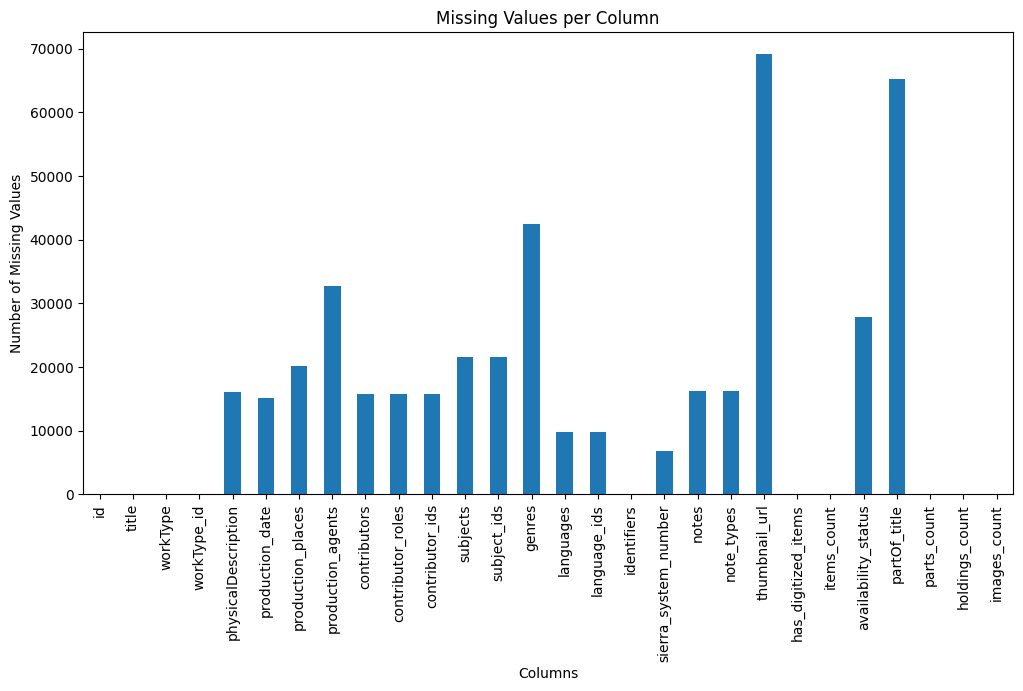


A random record from the dataframe:



,9247
id,dk759dua
title,John Bolton's cure for lung distemper in cattle : testimonials.
workType,Ephemera
workType_id,l
physicalDescription,1 sheet
production_date,[1855?]
production_places,[United Kingdom]
production_agents,[publisher not identified]
contributors,None
contributor_roles,None


In [4]:
# shape of the dataset
print(f"\nOur filtered dataset has: {filtered.shape[1]} columns and {filtered.shape[0]} rows.")

# how many missing values per column
missing_values = filtered.isnull().sum()

plt.figure(figsize=(12,6))
plt.title("Missing Values per Column")
missing_values.plot(kind='bar')
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show();

print_one_random_record(filtered)

We have now a dataframe more or less filtered but we still have a lot of columns that make no sense to use for our task, for example the _identifiers_ or the _urls_. We will have to do some more __feature selection__.

In [8]:
# Remove non-predictable columns and with no corelation to the target
columns_to_remove = [
    # System IDs - just internal database identifiers, not predictable
    'id', 'workType_id', 'contributor_ids', 'subject_ids', 'language_ids', 
    'identifiers', 'sierra_system_number',
    
    # Counts - database metadata, not intrinsic properties of the work
    'items_count', 'parts_count', 'holdings_count', 'images_count',
    
    # Operational data - library-specific, not about the work itself
    'has_digitized_items', 'availability_status',
    
    # Less useful duplicates - keep the main version, remove auxiliary
    'note_types'  # Keep 'notes', remove the types since notes contain more info
]
necessary_df = filtered.copy().drop(columns=columns_to_remove);

# Display percentage of missing values per column with a custom styled table
null_pct = necessary_df.isnull().mean().sort_values(ascending=False) * 100
df_null = pd.DataFrame({
    "Column": null_pct.index,
    "% Null": [f"{v:.2f}%" for v in null_pct.values]
})

css = """
<style> 
.table-fixed {border-collapse: collapse; width: 70%; max-width: 900px;} 
.table-fixed th, 
.table-fixed td {border: 1px solid #ddd; padding: 6px 10px; text-align: left;} 
.table-fixed th {background:#808080; font-weight:600;} 
</style>
"""
display(HTML(css + df_null.to_html(index=False, classes="table-fixed", escape=False)))

Column,% Null
thumbnail_url,69.12%
partOf_title,65.23%
genres,42.40%
production_agents,32.71%
subjects,21.62%
production_places,20.16%
notes,16.23%
physicalDescription,16.12%
contributors,15.71%
contributor_roles,15.71%


In [10]:
print_one_random_record(necessary_df)


A random record from the dataframe:



,653
title,George Morewood Lefferts.
workType,Books
physicalDescription,pages 398-400 : portrait
production_date,1923
production_places,New York (State)
production_agents,None
contributors,None
contributor_roles,None
subjects,"Lefferts, George Morewood, 1846-1920."
genres,None


__Our dataset only contains columns that interest us.__ 

# Preprocessing
We now have to __preprocess__ the data. The goal is to predict missing values in the dataset using the other fields as input so we will not have to fill NaNs. But we still have to deal with classic preprocessings such as categorical variables encoding, text vectorization and normalization.